# Try Li Plating Sub Models

In [1]:
import pybamm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
import dfols
import signal
from scipy.integrate import solve_ivp
from scipy.fft import fft, fftfreq, fftshift
from scipy.signal import savgol_filter
from scipy.signal import find_peaks
from scipy import interpolate
from stopit import threading_timeoutable as timeoutable
import os, sys
sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath("__file__"))))
from batfuns import *
plt.rcParams = set_rc_params(plt.rcParams)

eSOH_DIR = "../data/esoh/"
oCV_DIR = "../data/ocv/"
fig_DIR = "../figures/figures_model/"
res_DIR = "../data/results_model/"
%matplotlib widget

In [2]:
parameter_values = get_parameter_values()

In [3]:
spm = pybamm.lithium_ion.SPM(
    {
        "SEI": "ec reaction limited",
        "loss of active material": "stress-driven",
    }
)
spm_li = pybamm.lithium_ion.SPM(
    {
        "SEI": "ec reaction limited",
        "loss of active material": "stress-driven",
        "lithium plating": "irreversible",
    }
)

spm_li_r = pybamm.lithium_ion.SPM(
    {
        "SEI": "ec reaction limited",
        "loss of active material": "stress-driven",
        "lithium plating": "reversible",
    }
)

spm_li_pr = pybamm.lithium_ion.SPM(
    {
        "SEI": "ec reaction limited",
        "loss of active material": "stress-driven",
        "lithium plating": "partially reversible",
    }
)

spme = pybamm.lithium_ion.SPMe(
    {
        "SEI": "ec reaction limited",
        "loss of active material": "stress-driven",
    }
)
spme_li = pybamm.lithium_ion.SPMe(
    {
        "SEI": "ec reaction limited",
        "loss of active material": "stress-driven",
        "lithium plating": "irreversible",
    }
)

dfn_li = pybamm.lithium_ion.DFN(
    {
        "SEI": "ec reaction limited",
        "loss of active material": "stress-driven",
        "lithium plating": "irreversible",
    }
)
# spm.print_parameter_info()
param=spm_li.param

In [4]:
cell = 4
cell_no,dfe,dfe_0,dfo_0,N,N_0 = load_data(cell,eSOH_DIR,oCV_DIR)
eps_n_data,eps_p_data,c_rate_c,c_rate_d,dis_set,Temp,SOC_0 = init_exp(cell_no,dfe,spm,parameter_values)
print(Temp)

25


In [5]:
parameter_values.update(
    {
      "Negative electrode active material volume fraction": eps_n_data,
      "Positive electrode active material volume fraction": eps_p_data,
      "Positive electrode LAM constant proportional term [s-1]": 1.27152e-07,
      "Negative electrode LAM constant proportional term [s-1]": 1.27272e-06,
      "Positive electrode LAM constant exponential term": 1.1992,
      "Negative electrode LAM constant exponential term": 1.1992,
      "SEI kinetic rate constant [m.s-1]":  4.60788219e-16, #1.08494281e-16 , 
      "EC diffusivity [m2.s-1]": 4.56607447e-19,#8.30909086e-19,
      "SEI growth activation energy [J.mol-1]": 1.87422275e+04,#1.58777981e+04,
      "Lithium plating kinetic rate constant [m.s-1]": 1e-9,
      "Negative electrode reference exchange-current density [A.m-2(m3.mol)1.5]": 4.244E-6,
      "Li plating open-circuit potential [V]":0.0,
      # "Lithium plating transfer coefficient": 0.65,
      # "Exchange-current density for plating [A.m-2]":0.002,
      # "Lithium plating transfer coefficient": 0.7,
      # "Dead lithium decay constant [s-1]": 1E-4,
    },
    check_already_exists=False,
)

In [6]:
parameter_values.search('voltage')

Lower voltage cut-off [V]	3.0
Upper voltage cut-off [V]	4.2


In [7]:
# c_rate_d = '2C'
# c_rate_c = '1.5C'
c_rate_c ='C/5'
SOC_0 = 0

In [8]:
# pybamm.set_logging_level("WARNING")
pybamm.set_logging_level("NOTICE")
# pybamm.set_logging_level("INFO")
# pybamm.set_logging_level("VERBOSE")
# pybamm.set_logging_level("SPAM")
experiment = pybamm.Experiment(
    [
        (
        #  "Rest for 10 minutes", 
         "Charge at "+c_rate_c+" until 4.2V", 
         "Hold at 4.2V until C/50",
        #  "Rest for 20 minutes",
         )
    ],
    termination="50% capacity",
#     cccv_handling="ode",
)

# experiment = pybamm.Experiment(
#     [
#         (
#          "Charge at "+c_rate_c+" until 4.2V", 
#          "Hold at 4.2V until C/50",
#          "Rest for 5 min",
#          "Discharge at "+c_rate_d+" until 3V",
#          )
#     ],
#     termination="50% capacity",
# #     cccv_handling="ode",
# )
# SOC_0 = 0 

# experiment = pybamm.Experiment(
#     [
#         (
#         #  "Charge at "+c_rate_c+" until 4.2V", 
#         #  "Hold at 4.2V until C/50",
#         #  "Rest for 5 min",
#          "Discharge at "+c_rate_d+" until 3V",
#          )
#     ],
#     termination="50% capacity",
# #     cccv_handling="ode",
# )
# SOC_0 = 1

In [9]:
sim_long = pybamm.Simulation(spm_li, experiment=experiment, parameter_values=parameter_values, 
                            solver=pybamm.CasadiSolver("safe"))
sol_long = sim_long.solve(initial_soc=SOC_0)
solution1 = sol_long

sim_long1 = pybamm.Simulation(spme_li, experiment=experiment, parameter_values=parameter_values, 
                            solver=pybamm.CasadiSolver("safe"))
sol_long1 = sim_long1.solve(initial_soc=SOC_0)
solution1_spme = sol_long1

sim_long1 = pybamm.Simulation(dfn_li, experiment=experiment, parameter_values=parameter_values, 
                            solver=pybamm.CasadiSolver("safe"))
sol_long1 = sim_long1.solve(initial_soc=SOC_0)
solution1_dfn = sol_long1

2022-12-16 14:12:50.449 - [NOTICE] callbacks.on_cycle_start(174): Cycle 1/1 (16.030 ms elapsed) --------------------
2022-12-16 14:12:50.450 - [NOTICE] callbacks.on_step_start(182): Cycle 1/1, step 1/2: Charge at C/5 until 4.2V
2022-12-16 14:12:50.762 - [NOTICE] callbacks.on_step_start(182): Cycle 1/1, step 2/2: Hold at 4.2V until C/50
2022-12-16 14:12:51.148 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.782 Ah (originally 4.782 Ah, will stop at 2.391 Ah)
2022-12-16 14:12:51.150 - [NOTICE] callbacks.on_experiment_end(222): Finish experiment simulation, took 715.546 ms
2022-12-16 14:12:53.349 - [NOTICE] callbacks.on_cycle_start(174): Cycle 1/1 (18.157 ms elapsed) --------------------
2022-12-16 14:12:53.350 - [NOTICE] callbacks.on_step_start(182): Cycle 1/1, step 1/2: Charge at C/5 until 4.2V
2022-12-16 14:12:55.681 - [NOTICE] callbacks.on_step_start(182): Cycle 1/1, step 2/2: Hold at 4.2V until C/50
2022-12-16 14:12:56.942 - [NOTICE] callbacks.on_cycle_end(196): Capacity is

In [10]:
# parameter_values.update(
#     {
#     #   "Exchange-current density for plating [A.m-2]":0.001,
#     #   "Lithium plating transfer coefficient": 0.5,
#     #   "Dead lithium decay constant [s-1]": 1E-4,
#         # "Exchange-current density for stripping [A.m-2]": 0.00005,
#     },
#     check_already_exists=False,
# )
c_rate_c ='1.5C'
experiment = pybamm.Experiment(
    [
        (
        #  "Rest for 10 minutes",
         "Charge at "+c_rate_c+" until 4.2V", 
         "Hold at 4.2V until C/50",
        #  "Rest for 20 minutes",
         )
    ],
    termination="50% capacity",
#     cccv_handling="ode",
)
# experiment = pybamm.Experiment(
#     [
#         (
#          "Charge at "+c_rate_c+" until 4.2V", 
#          "Hold at 4.2V until C/50",
#          "Rest for 5 min",
#          "Discharge at "+c_rate_d+" until 3V",
#          )
#     ],
#     termination="50% capacity",
# #     cccv_handling="ode",
# )
# SOC_0 = 0 

sim_long = pybamm.Simulation(spm_li, experiment=experiment, parameter_values=parameter_values, 
                            solver=pybamm.CasadiSolver("safe"))
sol_long = sim_long.solve(initial_soc=SOC_0)
solution2 = sol_long

sim_long1 = pybamm.Simulation(spme_li, experiment=experiment, parameter_values=parameter_values, 
                            solver=pybamm.CasadiSolver("safe"))
sol_long1 = sim_long1.solve(initial_soc=SOC_0)
solution2_spme = sol_long1

sim_long1 = pybamm.Simulation(dfn_li, experiment=experiment, parameter_values=parameter_values, 
                            solver=pybamm.CasadiSolver("safe"))
sol_long1 = sim_long1.solve(initial_soc=SOC_0)
solution2_dfn = sol_long1

2022-12-16 14:13:09.173 - [NOTICE] callbacks.on_cycle_start(174): Cycle 1/1 (16.701 ms elapsed) --------------------
2022-12-16 14:13:09.174 - [NOTICE] callbacks.on_step_start(182): Cycle 1/1, step 1/2: Charge at 1.5C until 4.2V
2022-12-16 14:13:09.303 - [NOTICE] callbacks.on_step_start(182): Cycle 1/1, step 2/2: Hold at 4.2V until C/50
2022-12-16 14:13:09.633 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 4.823 Ah (originally 4.823 Ah, will stop at 2.412 Ah)
2022-12-16 14:13:09.634 - [NOTICE] callbacks.on_experiment_end(222): Finish experiment simulation, took 477.167 ms
2022-12-16 14:13:11.675 - [NOTICE] callbacks.on_cycle_start(174): Cycle 1/1 (22.858 ms elapsed) --------------------
2022-12-16 14:13:11.675 - [NOTICE] callbacks.on_step_start(182): Cycle 1/1, step 1/2: Charge at 1.5C until 4.2V
2022-12-16 14:13:12.362 - [NOTICE] callbacks.on_step_start(182): Cycle 1/1, step 2/2: Hold at 4.2V until C/50
2022-12-16 14:13:13.434 - [NOTICE] callbacks.on_cycle_end(196): Capacity 

In [11]:
# spm_li.variables.search("exchange")

In [12]:
spm_li.variables.search("potential")

Electrolyte potential
Electrolyte potential [V]
Gradient of electrolyte potential
Gradient of negative electrode potential
Gradient of negative electrolyte potential
Gradient of positive electrode potential
Gradient of positive electrolyte potential
Gradient of separator electrolyte potential
Negative current collector potential
Negative current collector potential [V]
Negative electrode SEI reaction overpotential
Negative electrode SEI reaction overpotential [V]
Negative electrode lithium plating reaction overpotential
Negative electrode lithium plating reaction overpotential [V]
Negative electrode open circuit potential
Negative electrode open circuit potential [V]
Negative electrode potential
Negative electrode potential [V]
Negative electrode reaction overpotential
Negative electrode reaction overpotential [V]
Negative electrode surface potential difference
Negative electrode surface potential difference [V]
Negative electrolyte potential
Negative electrolyte potential [V]
Positive

In [55]:
def plot_vars(solution):
    t =  solution["Time [s]"].entries
    t = t/3600
    V =  solution["Terminal voltage [V]"].entries
    I =  solution["Current [A]"].entries
    Q = -solution['Discharge capacity [A.h]'].entries
    Q_Li = solution["Loss of capacity to lithium plating [A.h]"].entries
    I_Li = solution["X-averaged lithium plating interfacial current density [A.m-2]"].entries

    I_de = solution["X-averaged negative electrode interfacial current density [A.m-2]"].entries
    I_st = solution["X-averaged lithium plating interfacial current density"].entries
    I_to = solution["X-averaged negative electrode total interfacial current density [A.m-2]"].entries

    phi_seif = solution["X-averaged SEI film overpotential [V]"].entries
    phi_sei  = solution["X-averaged negative electrode sei reaction overpotential [V]"].entries
    # phi_sei = 0
    phi_pl  = solution["X-averaged negative electrode lithium plating reaction overpotential [V]"].entries
    phi_pl_nd  = solution["X-averaged negative electrode lithium plating reaction overpotential"].entries
    phi_del = solution["X-averaged negative electrode surface potential difference [V]"].entries

    phi_ocp = solution["X-averaged negative electrode open circuit potential [V]"].entries
    phi_int = solution["X-averaged negative electrode reaction overpotential [V]"].entries

    i0_int = solution["X-averaged negative electrode exchange current density [A.m-2]"].entries
    phi_e_avg = solution["X-averaged negative electrolyte potential [V]"].entries
    c_e_avg = solution["X-averaged negative electrolyte concentration [mol.m-3]"].entries
    c_ss_n = solution["X-averaged negative particle surface concentration [mol.m-3]"].entries
    c_save_n1 = solution["R-averaged negative particle concentration [mol.m-3]"].entries
    nn = len(c_save_n1)
    c_s_sum=0
    for i in range(nn):
        c_s_sum+=c_save_n1[i,:]
    c_save_n = c_s_sum/nn
    c_s_n = solution["X-averaged negative particle concentration [mol.m-3]"].entries

    u_css_n = solution["X-averaged negative electrode open circuit potential [V]"].entries

    return t,V,I,Q,Q_Li,I_Li,I_de,I_st,I_to,phi_seif,phi_sei,phi_pl,phi_del,phi_ocp,phi_int,i0_int,phi_e_avg,c_e_avg,c_ss_n,c_save_n,c_s_n,u_css_n

In [45]:
c_save_n1 = solution1["R-averaged negative particle concentration [mol.m-3]"].entries

In [53]:
nn = len(c_save_n1)
c_s_sum=0
for i in range(nn):
    c_s_sum+=c_save_n1[i,:]
c_save_n = c_s_sum/nn

In [50]:
c_save_n1[1,:]+c_save_n1[2,:]

array([   96.31049025,   263.25055857,   430.18938666,   597.12473645,
         764.05304643,   930.9693292 ,  1097.86842067,  1264.74375238,
        1431.59327359,  1598.40933355,  1765.20010855,  1931.95496368,
        2098.68834328,  2265.39305942,  2432.08075829,  2598.74788821,
        2765.4028717 ,  2932.04372106,  3098.67650832,  3265.30021725,
        3431.91891326,  3598.53215989,  3765.1425095 ,  3931.74985372,
        4098.3556858 ,  4264.96005465,  4431.56375031,  4598.16684012,
        4764.76967138,  4931.37217527,  5097.97444619,  5264.57604726,
        5431.17697212,  5597.7760165 ,  5764.37322978,  5930.96596148,
        6097.55454563,  6264.13390009,  6430.70507277,  6597.25965586,
        6763.80023315,  6930.31538905,  7096.81042987,  7263.27303803,
        7429.71181196,  7596.11507485,  7762.49340222,  7928.83417765,
        8095.14805758,  8261.41884437,  8427.65751095,  8593.84481878,
        8759.99436909,  8926.08850048,  9092.1445439 ,  9258.14979932,
      

In [56]:
t1,V1,I1,Q1,Q_Li1,I_Li1,I_de1,I_st1,I_to1,phi_seif1,phi_sei1,phi_pl1,phi_del1,phi_ocp1,phi_int1,i0_int1,phi_e_avg1,c_e_avg1,c_ss_n1,c_save_n1,c_s_n1,u_css_n1 = plot_vars(solution1)
t2,V2,I2,Q2,Q_Li2,I_Li2,I_de2,I_st2,I_to2,phi_seif2,phi_sei2,phi_pl2,phi_del2,phi_ocp2,phi_int2,i0_int2,phi_e_avg2,c_e_avg2,c_ss_n2,c_save_n2,c_s_n2,u_css_n2 = plot_vars(solution2)

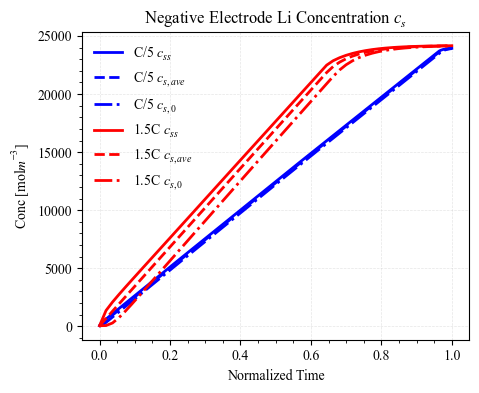

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
ax.plot(t1/t1[-1],c_ss_n1,'b')
ax.plot(t1/t1[-1],c_save_n1,'b--')
ax.plot(t1/t1[-1],c_s_n1[0,:],'b-.')
ax.plot(t2/t2[-1],c_ss_n2,'r')
ax.plot(t2/t2[-1],c_save_n2,'r--')
ax.plot(t2/t2[-1],c_s_n2[0,:],'r-.')
ax.legend([r"C/5 $c_{ss}$",r"C/5 $c_{s,ave}$",r"C/5 $c_{s,0}$",r"1.5C $c_{ss}$",r"1.5C $c_{s,ave}$",r"1.5C $c_{s,0}$"])
ax.set_xlabel("Normalized Time")
ax.set_ylabel("Conc [mol$m^{-3}$]")
ax.set_title(r'Negative Electrode Li Concentration $c_s$')
fig.savefig(fig_DIR+"neg_conc_crate_comp"+".png")

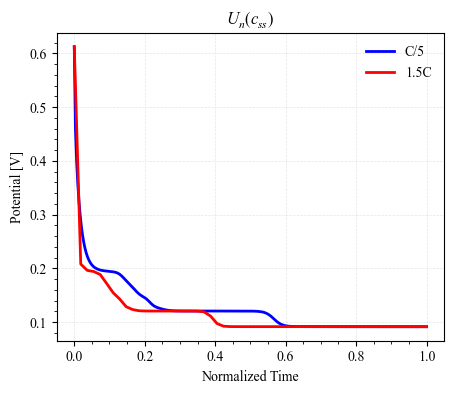

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
ax.plot(t1/t1[-1],u_css_n1,'b')
ax.plot(t2/t2[-1],u_css_n2,'r')
ax.legend(["C/5","1.5C"])
ax.set_xlabel("Normalized Time")
ax.set_ylabel("Potential [V]")
ax.set_title(r'$U_n(c_{ss})$')
fig.savefig(fig_DIR+"neg_pot_crate_comp"+".png")

Text(0.5, 1.0, 'Negative Electrode Li Concentration Difference $c_s$')

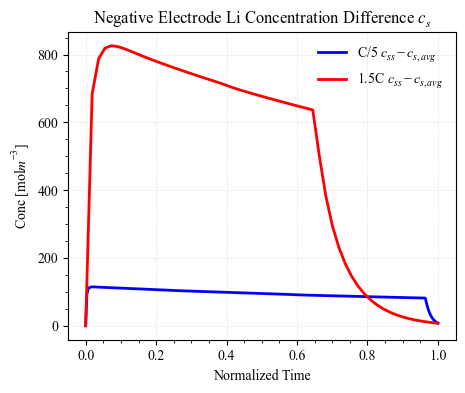

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
ax.plot(t1/t1[-1],c_ss_n1-c_save_n1,'b')
# ax.plot(t1/t1[-1],c_save_n1-c_s_n1[0,:],'b--')
# ax.plot(t1/t1[-1],c_s_n1[0,:],'b-.')
ax.plot(t2/t2[-1],c_ss_n2-c_save_n2,'r')
# ax.plot(t2/t2[-1],c_save_n2-c_s_n2[0,:],'r--')
# ax.plot(t2/t2[-1],c_s_n2[0,:],'r-.')
ax.legend([r"C/5 $c_{ss}-c_{s,avg}$",r"1.5C $c_{ss}-c_{s,avg}$"])
ax.set_xlabel("Normalized Time")
ax.set_ylabel("Conc [mol$m^{-3}$]")
ax.set_title(r'Negative Electrode Li Concentration Difference $c_s$')

In [18]:
len(t1)

299

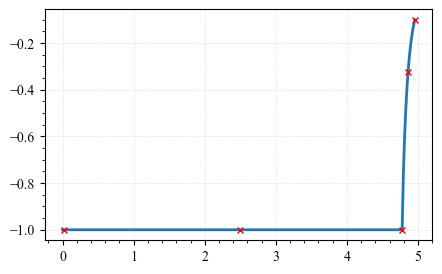

In [19]:
fig, ax1 = plt.subplots(1, 1, figsize=(5,3))
ax1.plot(t1,I1)
n=1
ax1.plot(t1[n],I1[n],'rx')
n=150
ax1.plot(t1[n],I1[n],'rx')
n=287
ax1.plot(t1[n],I1[n],'rx')
n=292
ax1.plot(t1[n],I1[n],'rx')
n=298
ax1.plot(t1[n],I1[n],'rx')

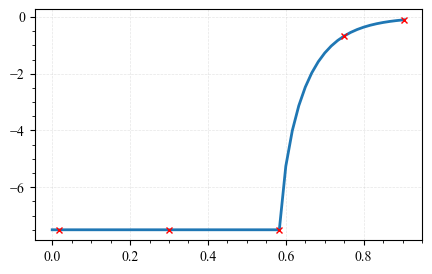

In [20]:
fig, ax1 = plt.subplots(1, 1, figsize=(5,3))
ax1.plot(t2,I2)
n=1
ax1.plot(t2[n],I2[n],'rx')
n=18
ax1.plot(t2[n],I2[n],'rx')
n=36
ax1.plot(t2[n],I2[n],'rx')
n=46
ax1.plot(t2[n],I2[n],'rx')
n=56
ax1.plot(t2[n],I2[n],'rx')

0.0002777777777777778


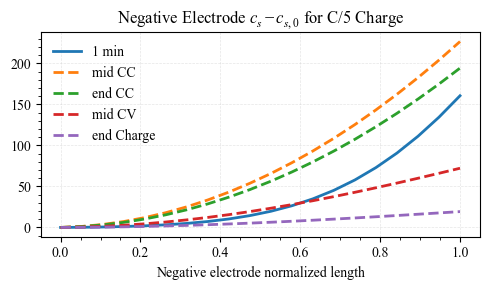

In [21]:
ln = np.linspace(0,1,20)
n = 1
print(t1[n]/60)
y1 = c_s_n1[:,n]-c_s_n1[0,n]
n = 150
y2 = c_s_n1[:,n]-c_s_n1[0,n]
n = 287
y3 = c_s_n1[:,n]-c_s_n1[0,n]
n = 292
y4 = c_s_n1[:,n]-c_s_n1[0,n]
n = 298
y5 = c_s_n1[:,n]-c_s_n1[0,n]
fig, ax1 = plt.subplots(1, 1, figsize=(5,3))
ax1.plot(ln,y1)
ax1.plot(ln,y2,'--')
ax1.plot(ln,y3,'--')
ax1.plot(ln,y4,'--')
ax1.plot(ln,y5,'--')
ax1.set_title(r'Negative Electrode $c_s-c_{s,0}$ for C/5 Charge')
ax1.set_xlabel("Negative electrode normalized length")
ax1.legend(["1 min","mid CC","end CC","mid CV","end Charge"])
# ax1.legend(['C/5','1.5 C'])
fig.tight_layout()
plt.savefig(fig_DIR+'spm_c_s_r_c5'+'.png')

0.0002777777777777778


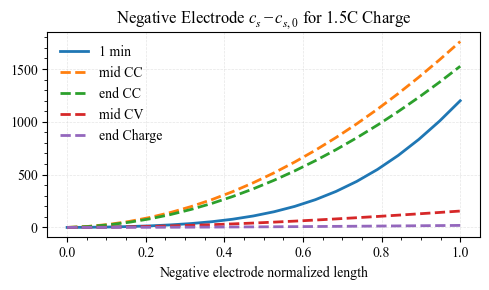

In [22]:
ln = np.linspace(0,1,20)
n = 1
print(t1[n]/60)
y1 = c_s_n2[:,n]-c_s_n2[0,n]
n = 18
y2 = c_s_n2[:,n]-c_s_n2[0,n]
n = 36
y3 = c_s_n2[:,n]-c_s_n2[0,n]
n = 46
y4 = c_s_n2[:,n]-c_s_n2[0,n]
n = 56
y5 = c_s_n2[:,n]-c_s_n2[0,n]
fig, ax1 = plt.subplots(1, 1, figsize=(5,3))
ax1.plot(ln,y1)
ax1.plot(ln,y2,'--')
ax1.plot(ln,y3,'--')
ax1.plot(ln,y4,'--')
ax1.plot(ln,y5,'--')
ax1.set_title(r'Negative Electrode $c_s-c_{s,0}$ for 1.5C Charge')
ax1.set_xlabel("Negative electrode normalized length")
ax1.legend(["1 min","mid CC","end CC","mid CV","end Charge"])
# ax1.legend(['C/5','1.5 C'])
fig.tight_layout()
plt.savefig(fig_DIR+'spm_c_s_r_1p5c'+'.png')

In [57]:
t2_spme,V2_spme,I2_spme,Q2_spme,Q_Li2_spme,I_Li2_spme,I_de2_spme,I_st2_spme,I_to2_spme,phi_seif2_spme,phi_sei2_spme,phi_pl2_spme,phi_del2_spme,phi_ocp2_spme,phi_int2_spme,i0_int2_spme,phi_e_avg2_spme,c_e_avg2_spme,c_ss_n2_spme,c_save_n2_spme,c_s_n2_spme,u_css_n2_spme = plot_vars(solution2_spme)

In [58]:
t2_dfn,V2_dfn,I2_dfn,Q2_dfn,Q_Li2_dfn,I_Li2_dfn,I_de2_dfn,I_st2_dfn,I_to2_dfn,phi_seif2_dfn,phi_sei2_dfn,phi_pl2_dfn,phi_del2_dfn,phi_ocp2_dfn,phi_int2_dfn,i0_int2_dfn,phi_e_avg2_dfn,c_e_avg2_dfn,c_ss_n2_dfn,c_save_n2_dfn,c_s_n2_dfn,u_css_n2_dfn = plot_vars(solution2_dfn)

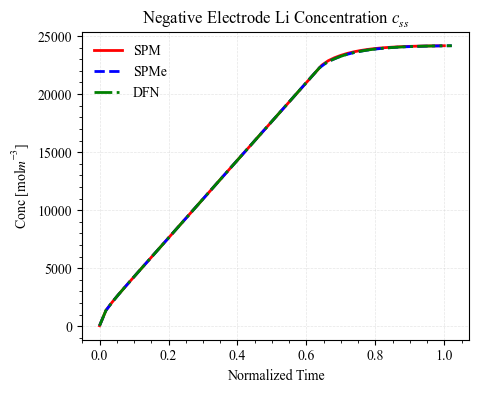

In [29]:
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
ax.plot(t2/t2[-1],c_ss_n2,'r')
ax.plot(t2_spme/t2[-1],c_ss_n2_spme,'b--')
ax.plot(t2_dfn/t2[-1],c_ss_n2_dfn,'g-.')
ax.legend(["SPM","SPMe","DFN"])
ax.set_xlabel("Normalized Time")
ax.set_ylabel("Conc [mol$m^{-3}$]")
ax.set_title(r'Negative Electrode Li Concentration $c_{ss}$')
fig.savefig(fig_DIR+"neg_conc_model_comp"+".png")

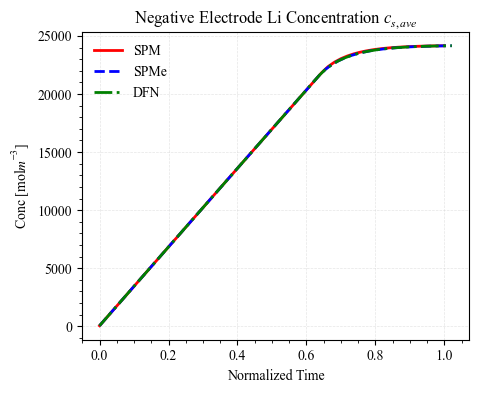

In [59]:
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
ax.plot(t2/t2[-1],c_save_n2,'r')
ax.plot(t2_spme/t2[-1],c_save_n2_spme,'b--')
ax.plot(t2_dfn/t2[-1],c_save_n2_dfn,'g-.')
ax.legend(["SPM","SPMe","DFN"])
ax.set_xlabel("Normalized Time")
ax.set_ylabel("Conc [mol$m^{-3}$]")
ax.set_title(r'Negative Electrode Li Concentration $c_{s,ave}$')
fig.savefig(fig_DIR+"neg_con_ave_model_comp"+".png")

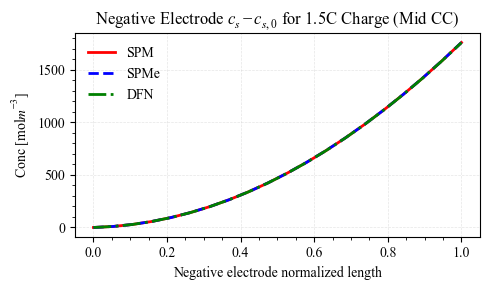

In [39]:
ln = np.linspace(0,1,20)
n = 18
y1 = c_s_n2[:,n]-c_s_n2[0,n]
n = 18
y2 = c_s_n2_spme[:,n]-c_s_n2_spme[0,n]
n = 18
y3 = c_s_n2_dfn[:,n]-c_s_n2_dfn[0,n]
fig, ax1 = plt.subplots(1, 1, figsize=(5,3))
ax1.plot(ln,y1,'r')
ax1.plot(ln,y2,'b--')
ax1.plot(ln,y3,'g-.')
ax1.set_title(r'Negative Electrode $c_s-c_{s,0}$ for 1.5C Charge (Mid CC)')
ax1.set_ylabel("Conc [mol$m^{-3}$]")
ax1.set_xlabel("Negative electrode normalized length")
ax1.legend(["SPM","SPMe","DFN"])
# ax1.legend(['C/5','1.5 C'])
fig.tight_layout()
plt.savefig(fig_DIR+'c_s_r_model_comp_1p5C'+'.png')

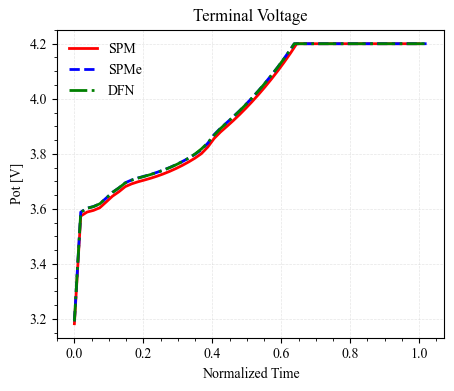

In [35]:
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
ax.plot(t2/t2[-1],V2,'r')
ax.plot(t2_spme/t2[-1],V2_spme,'b--')
ax.plot(t2_dfn/t2[-1],V2_dfn,'g-.')
ax.legend(["SPM","SPMe","DFN"])
ax.set_xlabel("Normalized Time")
ax.set_ylabel("Pot [V]")
ax.set_title(r'Terminal Voltage')
fig.savefig(fig_DIR+"voltage_model_comp"+".png")